# Maximum Likelihood: Theory

In [1]:
# Import some helper functions (please ignore this!)
from utils import * 

**Context:** At this point, our modeling toolkit is already getting quite expressive. 
1. We can develop simple *predictive models* using *conditional distributions*: we can specify models of the form $p_{A | B}(a | b)$, which allow us to predict the probability that $A = a$ given that $B = b$. We do this by specifying a distribution over random variable (RV) $A$, whose parameters are a *function* of $b$.  
2. We can develop simple *generative models* using *joint distributions*: we can specify models of the form $p_{A, B}(a, b)$, which allow us to sample (or generate) data. We do this by factorizing this joint probability into a product of conditional and marginal distributions, e.g. $p_{A, B}(a, b) = p_{A | B}(a | b) \cdot p_B(b)$, which we already know how to specify.

Of course, the predictive and generative models you may have heard about in the news are capable of doing more than the instances we've covert so far---we will build up to these fancy models over the course of the semester. What's important for now, though, is that you understand how such models can be represented using probability distributions. 

**Challenge:** So what stands in our way of applying our modeling tools to real-world data? First, we've only instantiated our models with *discrete* distributions. Many real-world data, however, requires *continuous* distributions; that is, distributions over real numbers (e.g. blood pressure, body-mass index, time spent in REM sleep, etc.). We'll get more into the details of continuous modeling a bit later. Our second obstacle is: we still don't have a way of *automatically* fitting a model to data. So far, you've fit all models to data by hand via inspection---you looked at the data and tried to match the model to the data. With increasing model and data complexity, it becomes prohibitively difficult to fit the model to the data by hand. Today, we'll introduce one technique for doing this: maximum likelihood estimation (MLE). This is the first algorithm that truly allows the "machine to learn."

The idea behind MLE is to find a model under which the probability of the data is highest. The intuition behind the MLE is that a model that scores the observed data as likely could have reasonably generated the data.

**Outline:**
* Formally introduce and motivate the MLE.
* Extend notation of directed graphical models (DGMs) to represent a full data-set instead of just one observation.
* Understand theoretical properties of the MLE.

This will give us the framing we need in order to implement MLE in `NumPyro`.

## MLE: Notation and Formalism

The idea behind the MLE is to find the model parameters that maximize the probability of the data. Let's introduce some notation to help us formalize what this means mathematically.

**Notation for Data.** Let $\mathcal{D}$ denote our *all* of our observed data ($\mathcal{D}$ represents the entirety of the above table). Let $\mathcal{D}_n$ represent observation number $n$ (i.e. row $n$) from the table. $\mathcal{D}_n$ is a tuple of values at each of the columns: $\mathcal{D}_n = (d_n, c_n, h_n, a_n, m_n)$. Recall that we define:
* $D$: Day-of-Week	
* $C$: Condition	
* $H$: Hospitalized	
* $A$: Antibiotics
* $M$: Attempts-to-Disentangle

**Notation for Parameters.** For simplicity, we've omitted the notation for each distribution's parameters from the notation so far. From now on, we'll explicitly write out the parameters as arguments to the distribution by listing them after a semi-colon. 
> For example, we can denote that a joint distribution over RVs $A$ and $B$ depends on a parameter $\theta$ as follows: $p_{A, B}(a, b; \theta)$. Similarly, we can write a conditional that depends on $\theta$ using $p_{A | B}(A | B; \theta)$.
>
> If different components of the distribution depend on different parameters, we can list them. For example, in a joint distribution over $A$ and $B$, we can have the conditional depend on $\theta$ and the marginal depend on $\phi$: $p_{A, B}(a, b; \theta, \phi) = p_{A | B}(a | b; \theta) \cdot p_B(b; \phi)$. 

**The MLE Objective.**
Let $\theta$ denote the set of all parameters used in our model for the IHH ER data. Using the above notation, $p_{D, C, H, A, M}(\mathcal{D}; \theta)$ denotes the probability of the observed data. Our goal is then to find the parameters $\theta$ that maximize the probability of having observed $\mathcal{D}$:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \quad p(\mathcal{D}; \theta),
\end{align}
wherein "argmax" denotes the value of $\theta$ that maximizes the joint probability. So what does it mean to evaluate the probability of the *whole data*, $\mathcal{D}$, under our model, $p_{D, C, H, A, M}$? It means evaluating the *joint distribution of all observations*, $\mathcal{D}_n = (d_n, c_n, h_n, a_n, m_n)$ for every $n \in [1, N]$:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \quad  p(\mathcal{D}; \theta) \\
&= \mathrm{argmax}_{\theta} \quad p(\mathcal{D}_1, \cdots, \mathcal{D}_N; \theta),
\end{align}
where $N$ is the total number of observations. 

Now, recall that every joint distribution can be factorized into a product of conditional and marginal distributions, and that the number of possible factorizations grows unwieldy very quickly with the number of variables. Since the number of variables in this joint distribution is a function of the number of observations, $N$, which is large (e.g. thousands), we need some way to select a reasonable factorization. As typical, we are going to assume that the observations are independent, and identically distributed (i.i.d). This means that one patient coming to the ER does not tell us anything about how likely other patients are to come to the ER. Now, recall that when two RVs are independent, their joint distribution equals a product of their marginals. We can therefore factorize the joint distribution as follows:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \quad  p(\mathcal{D}; \theta) \\
&= \mathrm{argmax}_{\theta} \quad p(\mathcal{D}_1, \cdots, \mathcal{D}_N; \theta) \\
&= \mathrm{argmax}_{\theta} \quad p(\mathcal{D}_1; \theta) \cdot p(\mathcal{D}_2; \theta) \cdots p(\mathcal{D}_N; \theta) \\
&= \mathrm{argmax}_{\theta} \quad \prod\limits_{n=1}^N p(\mathcal{D}_n; \theta) \\
&= \mathrm{argmax}_{\theta} \quad \prod\limits_{n=1}^N \underbrace{p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta)}_{\text{We already know how to compute this!}}
\end{align}
We have now arrived at a formula for the joint distribution that we know how to compute---we've even written code to evaluate it in `NumPyro`.

**Numerical Stability:** Notice that since our joint is a discrete probability distribution, it outputs probabilities between 0 and 1: $p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta) \in [0, 1]$. In other words, it outputs *fractions*. In the above formula, we then multiply these fractions times one another $N$ times. But what happens when you multiply fractions together many times? Answer: the results shrinks towards 0 very quickly (try it yourself!). This is a problem, because our computer can only represent small numbers up to a finite precision. For a large $N$, our computer will round down the answer to $0$, which will prevent us from performing the argmax. Because of this issue, we have to transform our original MLE objective into a problem that a computer can numerically solve. 

We do this by maximizing the $\log$ of the joint probability for two reasons:
1. Logs turn products into sums: $\log X \cdot Y = \log X + \log Y$. Applying this formula to our MLE objective results in a *sum* of fractions, which is numerically stable:
\begin{align}
\log \prod\limits_{n=1}^N p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta) = \sum\limits_{n=1}^N \log p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta)
\end{align}
2. But by maximizing the $\log$ of the joint probability instead, will we get the wrong answer? Because the $\log$ function is a *strictly increasing function*, our maxima will remain in the same location. That is:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \prod\limits_{n=1}^N p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta) \\
&= \mathrm{argmax}_{\theta} \sum\limits_{n=1}^N \log p_{D, C, H, A, M}(d_n, c_n, h_n, a_n, m_n; \theta)
\end{align}
To illustrate point (2), check out the graph below, which shows that the argmax of a function doesn't change if a $\log$ is applied to it.

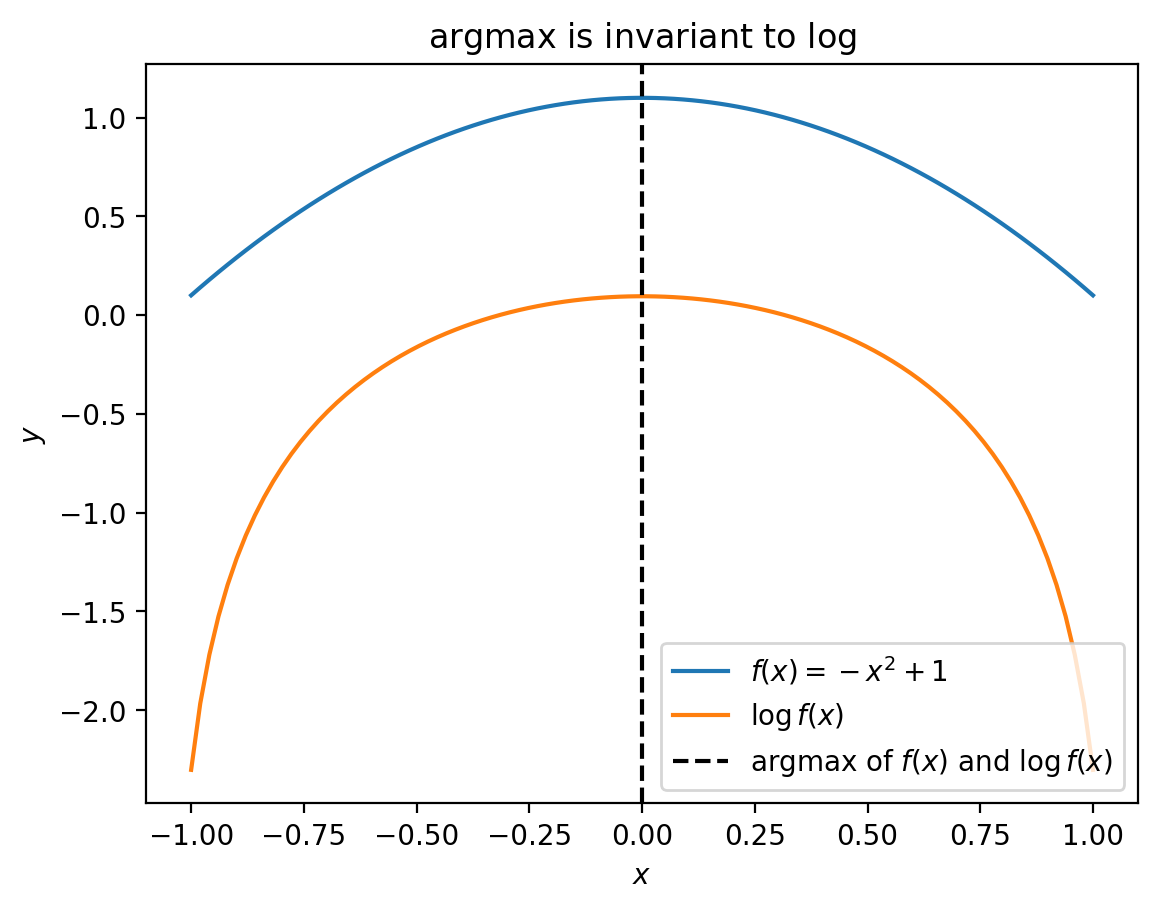

In [2]:
plot_invariance_of_argmax_under_log()

**Optimization:** So at this point, we can compute the MLE objective for specific choices of $\theta$, but we don't know yet how to perform the argmax operation. We'll introduce this concept a bit later in the course. For now, we'll provide you with a function that can perform the maximization.

## Graphically Representing I.I.D Observations and Model Parameters 

Before implementing the MLE in `NumPyro`, we will extend our Directed Graphical Model (DGM) representation to include i.i.d observations and model parameters. This will help us in the translation process from math to code. Suppose we have a simple joint distribution over two RVs, $A$ and $B$, whose conditional controlled by a parameter, $\theta$, as follows:
\begin{align}
p_{A, B}(a, b; \theta) &= p_{B | A}(b | a; \theta) \cdot p_A(a)
\end{align}
Suppose further that we have $N$ i.i.d observations from this joint distribution. That is, we have $\mathcal{D}_n = (a_n, b_n)$ for $n \in [1, N]$. This gives us the following joint distribution over the entire data:
\begin{align}
p(\mathcal{D}; \theta) &= \prod\limits_{n=1}^N p(\mathcal{D}_n; \theta) \quad \text{since the observations are i.i.d} \\
&= \prod\limits_{n=1}^N p_{A, B}(a_n, b_n; \theta) \\
&= \prod\limits_{n=1}^N p_{B | A}(b_n | a_n; \theta) \cdot p_A(a_n)
\end{align}
How would we represent this graphically? The answer is a little messy:
<div class="canva-centered-embedding">
<div class="canva-iframe-container">
  <iframe loading="lazy" class="canva-iframe"
    src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGIriW55zE&#x2F;pT0n6N3Vb4gqonaV360vkQ&#x2F;view?embed">
  </iframe>
</div>
</div>

Each pair $(A_n, B_n)$ get its own arrow to signify the conditional dependence of $B_n$ on $A_n$. And since every pair depends on the same parameter, $\theta$ has an arrow pointing into every $B_n$. 

**Representing Parameters.** In the above, notice that circles are only used for RVs. Since $\theta$ is not an RV, it is not inside a circle---it's represented by a dot instead.

**Representing I.I.D Observations:** For more complicated models, like the IHH ER you've already developed, this graphical representation becomes too difficult to read. As a result, we use the following short-hand:
<div class="canva-centered-embedding">
<div class="canva-iframe-container">
  <iframe loading="lazy" class="canva-iframe"
    src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGIrp4DCB8&#x2F;jGLx4K70R3JIS_kgnlL8Dg&#x2F;view?embed">
  </iframe>
</div>
</div>

In this representation, we introduce a "plate" (the rectangle surrounding $A_n$ and $B_n$). The plate denotes that what's inside should be repeated $N$ times, where $N$ is written in the bottom-right corner. Why is this called a plate? Do you eat off of rectangular plates at home? This shall remain a mystery to us all...

**A note on conditional independence:** We note that in this example model, for the IHH ER model you've developed, and generally for the models we consider in this class, the observations are only i.i.d given the model parameters. That is, given $\theta$, we can factorize $p(\mathcal{D}; \theta)$ into $\prod_{n=1}^N p(\mathcal{D}_n; \theta)$. However, if we do not "condition" on the parameters, $\theta$, the observations do carry knowledge about one another. That is, having observed $\mathcal{D}_1$ can tell me something about $\mathcal{D}_2$ because it tells me something about $\theta$, which is shared across all observations. More on that later in the course.

````{admonition} Exercise: Translate between DGMs and joint distributions
**Part 1:** Extend the DGM for the IHH ER below to represent the entirety of the data. Additionally, include all parameters of all distributions.

<div class="canva-centered-embedding">
<div class="canva-iframe-container">
  <iframe loading="lazy" class="canva-iframe"
    src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGIsbt2Mvc&#x2F;_p7bxsayZ9Qc6k9X8G25bw&#x2F;view?embed">
  </iframe>
</div>
</div> 

**Part 2:** For each of the following DGMs, write down the joint distribution of the data. We've specifically selected models that are commonly used in ML. At this point in the course, we have not covered enough materials to make the connection between the model and their actual use---so don't expect to understand exactly what they mean yet! 

(i) Predictive Models (including regression and classification).

<div class="canva-centered-embedding">
<div class="canva-iframe-container">
  <iframe loading="lazy" class="canva-iframe"
    src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGIs__Ja5w&#x2F;PVlm2FrOU1HjUyF96XXFhw&#x2F;view?embed">
  </iframe>
</div>
</div> 


(ii) Gaussian Mixture Models (used for clustering).

<div class="canva-centered-embedding">
<div class="canva-iframe-container">
  <iframe loading="lazy" class="canva-iframe"
    src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGIs1vP9i0&#x2F;-IWykjjF-dWy5DOBnqfudA&#x2F;view?embed">
  </iframe>
</div>
</div> 


(iii) Latent Dirichlet Allocation (used for automatically extracting topics from text).

<div class="canva-centered-embedding">
<div class="canva-iframe-container">
  <iframe loading="lazy" class="canva-iframe"
    src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGIs1zW89w&#x2F;AV6ehWRFRXZ4Y0xpddDcAw&#x2F;view?embed">
  </iframe>
</div>
</div> 

**Part 3:** Draw the DGM for each of the following models.

(iv) Conditional Subspace Variational Autoencoder (used for generating synthetic data, like pictures of celebrity faces)

\begin{align*}
\prod\limits_{n=1}^N p_{X | Z, W}(x_n | z_n, w_n; \theta) \cdot p_Z(z_n) \cdot p_{W | Y}(w_n | y_n) \cdot p_Y(y_n)
\end{align*}

(v) Hidden Markov Models (used for modeling time-series data).

\begin{align*}
p_{Z_1}(z_1; \psi) \cdot p_{X_1 | Z_1}(x_1 | z_1; \theta) \cdot \prod\limits_{t=2}^T p_{Z_t | Z_{t-1}}(z_t | z_{t - 1}; \psi) \cdot p_{X_t | Z_t}(x_t | z_t; \theta)
\end{align*}

Note: for this DGM, you will not be able to use plate notation. Instead, please use "$\dots$" to indicate a repeating pattern.
````

## Theoretical Properties of the MLE

TODO YANIV:
* Consistency
* Unbiasedness